<a href="https://colab.research.google.com/github/youjinchang/SportAnalysis/blob/main/COCO_04_HRNet_pred_OKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 클래스별 반복문 전처리
# 추론 클래스별로 가져오기
# IOU 박스 수정

# COCO dataset - Keypoints

* colab 에서 실행해본 버전입니다.  
* COCO_03_OKS.ipynb 내용에 HRNet으로 추론하는 부분 추가되었습니다.
* 런타임 유형 GPU로 먼저 바꿔놓고 코드 실행 바랍니다.

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

True


In [ ]:
baseDir = '/content/drive/MyDrive/COCO'

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir(baseDir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
import cv2
import matplotlib.image as image
import json
from PIL import Image
from PIL import Image, ImageFont, ImageDraw
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
dataDir='annotations_trainval2017'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)  # coco annotation file
print(annFile)

annotations_trainval2017/annotations/instances_val2017.json


In [ ]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


In [ ]:
catIds = coco.getCatIds(catNms=['person','snowboard'])  # 조건에 해당하는 class 번호 가져오기

In [ ]:
catIds

[1, 36]

In [ ]:
imgIds = coco.getImgIds(catIds=catIds)  # 해당하는 이미지 목록 가져오기
print(imgIds)

[343937, 562818, 42628, 378244, 426376, 411530, 117645, 97679, 217872, 80273, 184978, 490515, 193429, 563349, 309655, 44195, 561958, 428454, 109992, 492968, 400044, 425906, 95155, 463542, 37689, 36539, 361919, 23359, 350405, 402118, 142790, 125257, 387916, 364884, 341719, 94944, 407650, 451043, 447465, 74860, 456303, 326128, 89078, 516601, 491130, 470779, 393469, 97278]


In [ ]:
idx = 0
print(imgIds[idx])  # 이미지 하나 불러오기

343937


In [ ]:
img = coco.loadImgs(imgIds)[0]

In [ ]:
img

{'coco_url': 'http://images.cocodataset.org/val2017/000000343937.jpg',
 'date_captured': '2013-11-20 12:55:34',
 'file_name': '000000343937.jpg',
 'flickr_url': 'http://farm5.staticflickr.com/4072/4320314557_bfcc972543_z.jpg',
 'height': 428,
 'id': 343937,
 'license': 4,
 'width': 640}

In [ ]:
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType) # coco keypoint file
print(annFile)

annotations_trainval2017/annotations/person_keypoints_val2017.json


In [ ]:
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [ ]:
annIds = coco_kps.getAnnIds(imgIds=img['id'], iscrowd=None)
print(annIds)  # 불러온 이미지에 해당하는 annotation 불러오기

[425370]


In [ ]:
anns = coco_kps.loadAnns(annIds)

In [ ]:
image_id = anns[0]['image_id']
print(image_id)

343937


In [ ]:
person_id = 0
true_bbox = anns[person_id]['bbox']
print('gt_bbox : {}'.format(true_bbox))

gt_bbox : [275.07, 15.23, 134.66, 394.34]


In [ ]:
print(anns[0]['keypoints'])

[290, 69, 2, 300, 57, 2, 285, 57, 2, 315, 62, 2, 0, 0, 0, 333, 97, 2, 298, 106, 2, 350, 143, 2, 0, 0, 0, 353, 198, 2, 0, 0, 0, 336, 205, 2, 317, 209, 2, 344, 291, 2, 340, 278, 2, 378, 371, 2, 374, 363, 2]


In [ ]:
true_keypoint = np.array(anns[0]['keypoints'])
tx = true_keypoint[0::3]; ty = true_keypoint[1::3]; tv = true_keypoint[2::3]
print("xg shape {} {}\nyg shape {} {}\nvg shape {} {}\n".format(
    tx.shape, tx, ty.shape,ty, tv.shape,tv))

xg shape (17,) [290 300 285 315   0 333 298 350   0 353   0 336 317 344 340 378 374]
yg shape (17,) [ 69  57  57  62   0  97 106 143   0 198   0 205 209 291 278 371 363]
vg shape (17,) [2 2 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2]



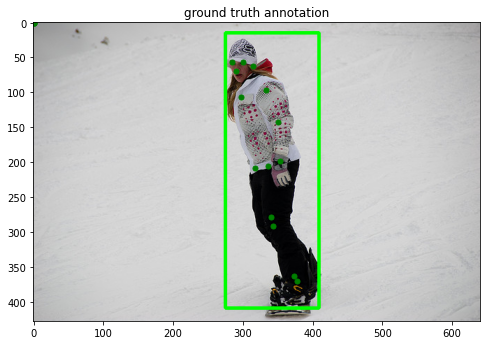

In [ ]:
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(true_bbox[0]), int(true_bbox[1])),
              (int(true_bbox[0])+int(true_bbox[2]), int(true_bbox[1])+int(true_bbox[3])),  #bbox 그리기
              (0,255,0), 4)
plt.plot(tx, ty, 'g.', markersize=10)  #keypoint 찍기
plt.imshow(image)
plt.title('ground truth annotation')
plt.show()

In [ ]:
# plt.imshow(image)
# coco_kps.showAnns(anns)

# HRNet - Keypoints Inference

In [ ]:
baseDir2 = '{}/simple-HRNet'.format(baseDir)

In [ ]:
#baseDir_downdog = '{}/yoga/downdog'.format(baseDir)
#baseDir_goddess = '{}/yoga/goddess'.format(baseDir)
#baseDir_plank = '{}/yoga/plank'.format(baseDir)
#baseDir_warrior2 = '{}/yoga/warrior2'.format(baseDir)

In [ ]:
%cd $baseDir2

/content/drive/MyDrive/COCO/simple-HRNet


In [ ]:
#%cd $baseDir_downdog
#%cd $baseDir_goddess
#%cd $baseDir_plank
#%cd $baseDir_warrior2

In [ ]:
!pwd

/content/drive/MyDrive/COCO/simple-HRNet


In [ ]:
img_dir_path = '{}/images'.format(baseDir2)
json_dir_path = '{}/json_output'.format(baseDir2)

In [ ]:
#img_dir_path_yoga_downdog = '{}/images'.format(baseDir_downdog)
#json_dir_path_yoga_downdog = '{}/json_output'.format(baseDir_downdog)

#img_dir_path_yoga_goddess = '{}/images'.format(baseDir_goddess)
#json_dir_path_yoga_goddess = '{}/json_output'.format(baseDir_goddess)

#img_dir_path_yoga_plank = '{}/images'.format(baseDir_plank)
#json_dir_path_yoga_plank = '{}/json_output'.format(baseDir_plank)

#img_dir_path_yoga_warrior2 = '{}/images'.format(baseDir_warrior2)
#json_dir_path_yoga_warrior2 = '{}/json_output'.format(baseDir_warrior2)

In [ ]:
#img_down_source = img['coco_url']
#img_down_name = img_down_source.split('/')[-1].split('.')[0]

In [ ]:
img_down_name = '00000285'

In [ ]:
print(img_down_name)

00000285


In [ ]:
img_file_name = '{}/{}.jpg'.format(img_dir_path, img_down_name)   # 필요시 확장자 수정
output_file_name = '{}/{}.json'.format(json_dir_path, img_down_name) 

In [ ]:
if os.path.exists(img_file_name):
    print('image file already exists')
else:
    !wget -P $img_dir_path $img_down_source  # 추론을 위한 이미지 다운로드

image file already exists


In [ ]:
print(img_file_name)
print(output_file_name)

/content/drive/MyDrive/COCO/simple-HRNet/images/00000285.jpg
/content/drive/MyDrive/COCO/simple-HRNet/json_output/00000285.json


Text(0.5, 1.0, 'downloaded image')

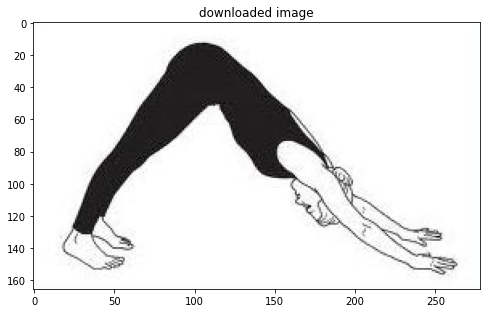

In [ ]:
# 다운받은 이미지 확인하기
orign_img = cv2.imread(img_file_name)
orign_img = cv2.cvtColor(orign_img, cv2.COLOR_RGB2BGR)
plt.imshow(orign_img)
plt.title("downloaded image")

In [ ]:
img = coco.loadImgs['img_file_name)

TypeError: ignored

In [ ]:
img

{'coco_url': 'http://images.cocodataset.org/val2017/000000343937.jpg',
 'date_captured': '2013-11-20 12:55:34',
 'file_name': '000000343937.jpg',
 'flickr_url': 'http://farm5.staticflickr.com/4072/4320314557_bfcc972543_z.jpg',
 'height': 428,
 'id': 343937,
 'license': 4,
 'width': 640}

## KeyPoint 추출

In [ ]:
!echo {img_file_name}

/content/drive/MyDrive/COCO/simple-HRNet/images/00000285.jpg


In [ ]:
!echo {output_file_name}

/content/drive/MyDrive/COCO/simple-HRNet/json_output/00000285.json


In [ ]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python3 scripts/extract-keypoints.py \
  --filename {img_file_name} \
  --format json \
  --hrnet_weights weights/pose_hrnet_w48_384x288.pth \
  --json_output_filename {output_file_name}

device: 'cuda' - 1 GPU(s) will be used
None
number of people :  1
bbox : 
 [[ 24   0 244 166]]
frame:    0 / 0 - framerate: 1.703058 fps 

## 추론 가져오기

In [ ]:
with open(output_file_name) as json_file:
    pred_anns = json.load(json_file)

In [ ]:
pred_anns

{'0': [[[24, 0, 244, 166]],
  [[[25.9375, 112.61111450195312, 0.0656265988945961],
    [114.125, 167.61111450195312, 0.10312073677778244],
    [24.20833396911621, 106.5, 0.05329234153032303],
    [27.66666603088379, 109.55555725097656, 0.08554775267839432],
    [108.9375, 185.94444274902344, 0.04832727834582329],
    [19.02083396911621, 109.55555725097656, 0.09863318502902985],
    [19.02083396911621, 112.61111450195312, 0.09647145867347717],
    [84.72916412353516, 54.55555725097656, 0.3274401128292084],
    [81.27083587646484, 57.61111068725586, 0.5324068665504456],
    [127.95833587646484, 30.11111068725586, 0.37187740206718445],
    [129.6875, 27.05555534362793, 0.4793393313884735],
    [24.20833396911621, 109.55555725097656, 0.18093641102313995],
    [24.20833396911621, 112.61111450195312, 0.31183385848999023],
    [27.66666603088379, 109.55555725097656, 0.080104298889637],
    [20.75, 109.55555725097656, 0.4944002032279968],
    [138.3333282470703, 240.94444274902344, 0.198498994

In [ ]:
pred_anns = pred_anns['0']
pred_bbox = pred_anns[0][0]

In [ ]:
pred_bbox

[24, 0, 244, 166]

In [ ]:
pred_keypoint = pred_anns[1][0]
pred = np.array(pred_keypoint).reshape(-1)
px = pred[1::3]; py = pred[0::3]
print("px shape {} {}\npy shape {} {}\n".format(
    px.shape, px, py.shape, py))

px shape (17,) [112.6111145  167.6111145  106.5        109.55555725 185.94444275
 109.55555725 112.6111145   54.55555725  57.61111069  30.11111069
  27.05555534 109.55555725 112.6111145  109.55555725 109.55555725
 240.94444275  27.05555534]
py shape (17,) [ 25.9375     114.125       24.20833397  27.66666603 108.9375
  19.02083397  19.02083397  84.72916412  81.27083588 127.95833588
 129.6875      24.20833397  24.20833397  27.66666603  20.75
 138.33332825 129.6875    ]



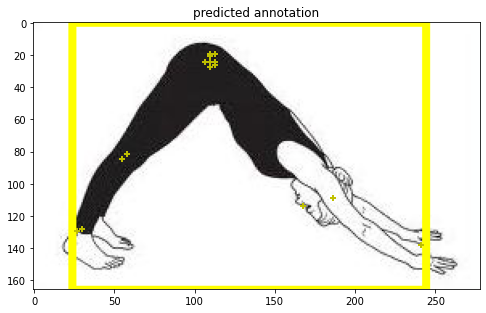

In [ ]:
#image = io.imread(img['coco_url'])
image = io.imread(img_file_name)
cv2.rectangle(image, 
              (int(pred_bbox[0]), int(pred_bbox[1])),
              (int(pred_bbox[2]), int(pred_bbox[3])),  #bbox 그리기
              (255,255,0), 4)
plt.plot(px, py, 'y+', markersize=6, markeredgewidth=2)  #keypoint 찍기
plt.title('predicted annotation')
plt.imshow(image)
plt.show()

In [ ]:
#downdog = []
#for i in range(len(df_all)-1):
#  patient_num = df_all['Path'].iloc[i].split('/')[2]
#  patient_num2 = df_all['Path'].iloc[i+1].split('/')[2]
#  print(df_all['Path'].iloc[i])
#  if patient_num != patient_num2:
#    patient.append(df_all.iloc[i])
#    print('----------------')

## OKS 계산하기

$ OKS = \large \Sigma_{i}{[exp(\frac{-d^2_i}{2s^2k^2_i}\delta(v_i > 0)]/\Sigma_{i}[\delta(v_{i}>0)]}$

In [ ]:
kpt_oks_sigmas = np.array(
    [.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
sigmas = kpt_oks_sigmas
vars = (sigmas * 2)**2
k = len(sigmas)
print('k={}'.format(k))

k=17


In [ ]:
x0 = true_bbox[0] - true_bbox[2]; x1 = true_bbox[0] + true_bbox[2] * 2
y0 = true_bbox[1] - true_bbox[3]; y1 = true_bbox[1] + true_bbox[3] * 2

print("true_bbox :",true_bbox)
print("tx shape {} {}\nty shape {} {}\ntv shape {} {}\n".format(
    tx.shape, tx, ty.shape,ty, tv.shape,tv))

true_bbox : [275.07, 15.23, 134.66, 394.34]
tx shape (17,) [290 300 285 315   0 333 298 350   0 353   0 336 317 344 340 378 374]
ty shape (17,) [ 69  57  57  62   0  97 106 143   0 198   0 205 209 291 278 371 363]
tv shape (17,) [2 2 2 2 0 2 2 2 0 2 0 2 2 2 2 2 2]



In [ ]:
print("pred_bbox :",pred_bbox)
print("px shape {} {}\npy shape {} {}".format(
    px.shape, px, py.shape,py))

pred_bbox : [24, 0, 244, 166]
px shape (17,) [112.6111145  167.6111145  106.5        109.55555725 185.94444275
 109.55555725 112.6111145   54.55555725  57.61111069  30.11111069
  27.05555534 109.55555725 112.6111145  109.55555725 109.55555725
 240.94444275  27.05555534]
py shape (17,) [ 25.9375     114.125       24.20833397  27.66666603 108.9375
  19.02083397  19.02083397  84.72916412  81.27083588 127.95833588
 129.6875      24.20833397  24.20833397  27.66666603  20.75
 138.33332825 129.6875    ]


In [ ]:
k1 = np.count_nonzero(tv > 0)
print(k,'-->',k1)

17 --> 14


In [ ]:
if k1>0:
    # measure the per-keypoint distance if keypoints visible
    dx = px - tx
    dy = py - ty
else:
    # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
    z = np.zeros((k))
    dx = np.max((z, x0-px),axis=0)+np.max((z, px-x1),axis=0)
    dy = np.max((z, y0-py),axis=0)+np.max((z, py-y1),axis=0)

In [ ]:
e = (dx**2 + dy**2) / vars / (anns[0]['area']+np.spacing(1)) / 2

In [ ]:
e

array([231.10594076, 155.96007217, 247.08615793, 166.05529305,
       177.7537363 ,  42.07599787,  31.50312434,  82.01582922,
         8.97549695, 133.14644936,  21.40681338,  34.38397899,
        31.09150574,  77.00165234,  73.88807944,  43.16104982,
       103.46929502])

In [ ]:
if k1 > 0:
    e=e[tv > 0]   # GT의 Visibility 처리
print('e >> ',e)

e >>  [231.10594076 155.96007217 247.08615793 166.05529305  42.07599787
  31.50312434  82.01582922 133.14644936  34.38397899  31.09150574
  77.00165234  73.88807944  43.16104982 103.46929502]


In [ ]:
oks = np.sum(np.exp(-e)) / e.shape[0]
print('OKS >> ',oks)

OKS >>  3.814086736997299e-15


## IoU 계산하기

In [ ]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [ ]:
true_bbox

[275.07, 15.23, 134.66, 394.34]

In [ ]:
true_bbox_1 = [None] *4
true_bbox_1[0] = true_bbox[0]; true_bbox_1[1] = true_bbox[1]
true_bbox_1[2] = true_bbox[0]+true_bbox[2]; true_bbox_1[3] = true_bbox[1]+true_bbox[3]

In [ ]:
true_bbox_1

[275.07, 15.23, 409.73, 409.57]

In [ ]:
pred_bbox

[24, 0, 244, 166]

In [ ]:
iou = IoU(true_bbox_1, pred_bbox)
print('IoU >> ', iou)

IoU >>  0.0


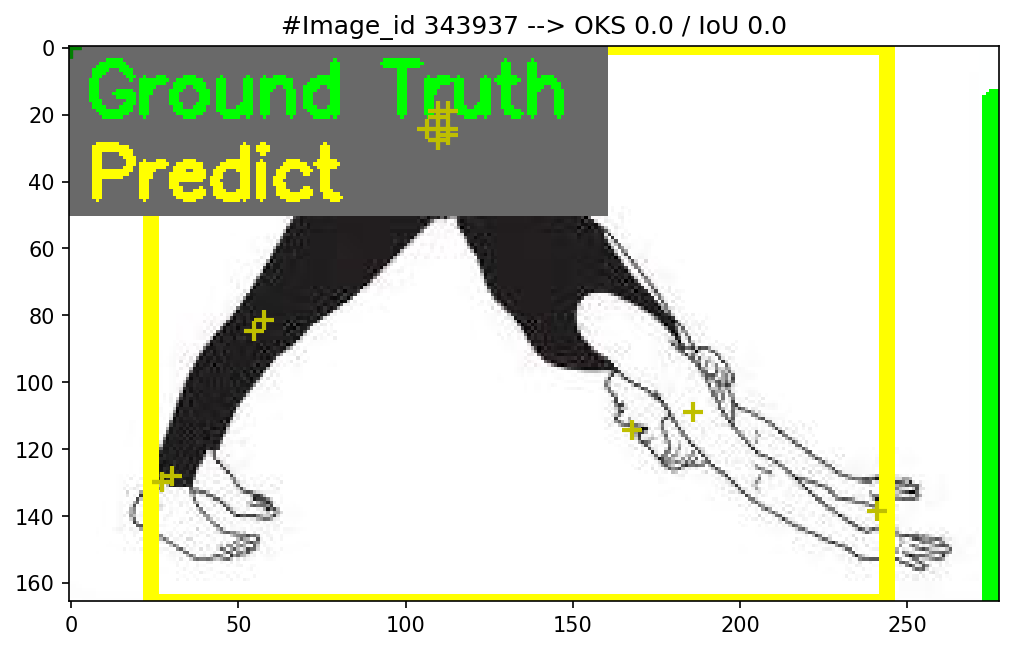

In [ ]:
fig = plt.figure(dpi = 150)
cv2.rectangle(image, 
              (int(true_bbox[0]), int(true_bbox[1])),
              (int(true_bbox[0])+int(true_bbox[2]), int(true_bbox[1])+int(true_bbox[3])),
              (0,255,0), 4)

plt.plot(px, py, 'y+', markersize=10, markeredgewidth=2)
plt.plot(tx, ty, 'g+', markersize=10, markeredgewidth=1.5)  #markerfacecolor=1
plt.title('#Image_id {} --> OKS {} / IoU {}'.format(image_id, round(oks, 3), round(iou, 3)))

cv2.rectangle(image, (0, 0), (160, 50), (105,105,105), -1)  #(0,0,0) -> black
cv2.putText(image, 'Ground Truth', (5,20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
cv2.putText(image, 'Predict', (5,45), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

plt.imshow(image)
plt.show()